Allowed libraries: sklearn, matplotlib, pandas, numpy

Dataset: bitstrings.csv

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.cluster import AgglomerativeClustering, KMeans

# Q1 [25 pts]

Load the data from the provided .csv file into a pandas dataframe, it contains a list of 1200 bitstrings which each have a length of 16 bits. Call the dataset 
S. We call two bitstrings A and B equivalent (A∼B) if you can flip one bit at a time starting from A to produce a sequence of strings A,s1,s2,...,sn,B∈S that are all within the dataset to get the string B. Through this notion of equivalence, we may define an equivalence relation on this set of bit strings. Using agglomerative clustering (sklearn) with a tolerance on distance for early stopping, we can compute the number of equivalence classes by counting the number of clusters. 

In order to do this, which **linkage rule** should be used (single-linkage, complete-linkage, or average-linkage), which **distance function** should be used (Euclidiean distance, Manhattan distance, or cosine distance), and what should the **threshold distance** be? (`distance_threshold`) Explain why you would pick these parameters.

Hints:

- An example of an equivalence: Let  S = {0000, 0010, 0110, 1100}. (0000∼0110) because there is a sequence of one bit changes you can make to get from 0000 to 0110 in S: 0000, 0010, 0110. But 1100 is not equivalent to any of the other ones. So {0000,0010,0110} form an equivalence class and {1100} is the other, thus there are 2 clusters.

- To use early stopping with tolerance in agglomerative clustering, each time the two closest clusters are about to be merged, the distance between those clusters is compared to the tolerance. If the distance is smaller than the tolerance, the clusters merge and the algorithm continues, otherwise, they aren't merged and the algorithm terminates.

- To find out which linkage rule to use, think about how you would figure out which equivalence class the string 0001 belongs to in the example from the first hint.


In [2]:
# linkage: single (closest), complete (furthest), average (every combination)
    # it defines cluster distance, not points distance
# distance: euclidean, MANHATTAN (up/down, then left/right), cosine (angle)
S = pd.read_csv("bitstrings.csv", names=['b1','b2','b3','b4','b5','b6','b7','b8','b9',
                                         'b10','b11','b12','b13','b14','b15','b16'])
print(S.head(3))

   b1  b2  b3  b4  b5  b6  b7  b8  b9  b10  b11  b12  b13  b14  b15  b16
0   0   0   0   0   0   0   1   1   0    1    1    1    1    1    0    0
1   0   0   0   0   0   0   1   1   0    0    1    1    1    1    0    0
2   0   0   0   0   0   0   0   1   0    0    1    1    1    1    0    0


**First, my reasoning**: Let's say we have some ("flattened out" multidimensional) grid, and we have groups of points on the grid at different locations/dimensions. The most important part about the groups of points is that the distances from the next closest are each 1, such that we can connect all these points with a line that is made up of 1-unit segments (each individual segment, btwn. two points, is no more than one unit long).

```
0 1 0 0 0 0 1-1 
  |           |
0 1-1-1 0 0 0 1    >> single linkage:   2      # closest distance works best 
      |       |    >> complete linkage: 8?     # (we must connect groups)
0 0 0 1-1 0 1-1    >> average linkage:  ?

          ^
now replace this bit with a 1

0 1 0 0 0 0 1-1 
  |           |
0 1-1-1 0 0 0 1    >> single linkage:   1      # now they're the same group!
      |       |    >> complete linkage: 7?     # but not with other linkages
0 0 0 1-1=1=1-1    >> average linkage:  ?      # (still greater than 1)
```
## My Answers to \#1: 

Linkage Rule: **Single**
- In order to determine whether a given bit string is in the same group as another, we should be able to draw 1-unit line segments throughout the entire group, including the given bit string. By this logic, to determine whether two groups are the same, the two **closest** points between the groups should be measured; to be the same group, they can only be ≤1 unit apart, and if they are >1 unit apart, they are different groups. 
    - These line segments are only in one dimension, but the dimension it is in can vary; e.g. 11010 and 01010 has a 1-unit difference (line segment) in the fifth dimension, and this difference (line segment) is in the fifth dimension only. Single linkage works best here because it always ignores other dimensions when finding the distance between points; e.g. looking in the fifth dimension only, before looking at other ones; and therefore, correctly isolates bitwise differences.

Distance Function: **Manhattan distance**
- There can only be a difference of exactly 1 bit between two elements in the same group, not a Euclidean distance (e.g. √(1+1)) or anything larger. Furthermore, the data is multidimensional, and Manhattan distance is most associated with dimensions in the data. Manhattan distance will also not take the shortest path through multiple dimensions (e.g. drawing a single line from (0,0,0) to (1,1,1)), instead only going through 1 dimension at a time, which fits this problem.

Threshold Distance: **> 1**
- Any bitstring with 1 bit's difference from the members of a group, is also a member of that group. Conversely, points further than 1 unit from a group are not members of that group.

# Q2 [25 pts]

Perform the clustering using the parameters you picked in Q1. How many equivalence classes (clusters) are there? 

Create a **bar plot**, showing the **number of strings in each cluster**. (You may need to increase your distance threshold slightly if you don't want the algorithm to terminate when the distance is equal to the threshold.)

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
clustered = AgglomerativeClustering(n_clusters=None, affinity='manhattan', linkage='single', distance_threshold=1.1).fit(S)
# print(type(clustered))
# print(type(clustered.labels_))
results = clustered.labels_
len(set(results))

32

**There are 32 equivalence classes in this dataset.**

7     296
5     194
0     193
2     187
1     100
6     100
3      99
4       3
8       3
10      2
12      2
30      1
9       1
11      1
13      1
dtype: int64


<AxesSubplot:xlabel='Group Numbers'>

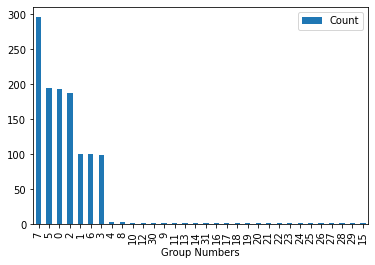

In [4]:
temp = pd.DataFrame(results).value_counts()
print(temp[:15])
# https://stackoverflow.com/questions/48761486/pandas-unable-to-reset-index-because-name-exist/58497173#58497173
temp2 = temp.reset_index(name="Count")   #M: ValueError: 0 already exists in the df, had to keep as Series
pd.DataFrame(temp2).plot.bar(x=0, y="Count", xlabel="Group Numbers")    #M: 0 was an int, not str

# Q3 [10 pts]

Using this clustering, determine if (0000001101111100 ∼ 1011101101111101). 

What about (1001111011001001 ∼ 1001111011000000)? 

(You need to show that you used this clustering to determine the answer).

In [5]:
## Find index of first, then 2nd, and see if they share the same cluster label
# https://stackoverflow.com/questions/42796085/finding-elements-in-a-pandas-dataframe
## 000000|110111|1100 ∼ 101110|110111|1101
## 100111|101100|1001 ∼ 100111|101100|0000
index11 = ((S.query('b1==0 & b2==0 & b3==0 & b4==0 & b5==0 & b6==0 & \
              b7==1 & b8==1 & b9==0 & b10==1 & b11==1 & b12==1 & \
              b13==1 & b14==1 & b15==0 & b16==0').index)[0])
index12 = ((S.query('b1==1 & b2==0 & b3==1 & b4==1 & b5==1 & b6==0 & \
              b7==1 & b8==1 & b9==0 & b10==1 & b11==1 & b12==1 & \
              b13==1 & b14==1 & b15==0 & b16==1').index)[0])
index21 = ((S.query('b1==1 & b2==0 & b3==0 & b4==1 & b5==1 & b6==1 & \
              b7==1 & b8==0 & b9==1 & b10==1 & b11==0 & b12==0 & \
              b13==1 & b14==0 & b15==0 & b16==1').index)[0])
index22 = ((S.query('b1==1 & b2==0 & b3==0 & b4==1 & b5==1 & b6==1 & \
              b7==1 & b8==0 & b9==1 & b10==1 & b11==0 & b12==0 & \
              b13==0 & b14==0 & b15==0 & b16==0').index)[0])

In [6]:
# Using the clustering results to find the answer
print(results[index11])
print(results[index12])
print(results[index21])
print(results[index22])

7
7
5
25


**The first pair of bitstrings are in the same cluster, but not the second pair.**

# Q4 [20 pts]

Redo the clustering on the dataset, but this time using both of the other linkage rules (keep everything else the same), and report the number of clusters for both. 

Is there any difference from the number of clusters you found in Q2? If so, explain why.

In [7]:
clustered2 = AgglomerativeClustering(n_clusters=None, affinity='manhattan', linkage='complete', distance_threshold=1.1).fit(S)
results2 = clustered2.labels_
pd.DataFrame(results2).value_counts()

115    10
2       9
163     9
153     8
96      8
       ..
407     1
408     1
409     1
410     1
308     1
Length: 618, dtype: int64

**There are 618 clusters when using complete linkage, everything else held constant.**

In [8]:
clustered3 = AgglomerativeClustering(n_clusters=None, affinity='manhattan', linkage='average', distance_threshold=1.1).fit(S)
results3 = clustered3.labels_
pd.DataFrame(results3).value_counts()

73     13
44     12
35     10
127    10
92      9
       ..
417     1
420     1
421     1
422     1
308     1
Length: 617, dtype: int64

**There are 617 clusters when using average linkage, everything else held constant.**

- **There seem to be far more clusters with these linkages, with other parameters held constant. All of the data points are at least one bit away from each other, and simple linkage is the one that measures closest distances only, so it makes sense that looking any further than the closest two points will result in much smaller - and therefore more numerous - clusters (at least when using the same distance).**

# Q5 [20 pts]

Cluster the dataset again, this time using K-means clustering with the number of clusters set to the number you found in Q2. Create a bar plot for the size of the clusters. 

Compare with your plot in Q2, how do these results differ? Give an explanation for this difference.

<AxesSubplot:xlabel='Group Numbers'>

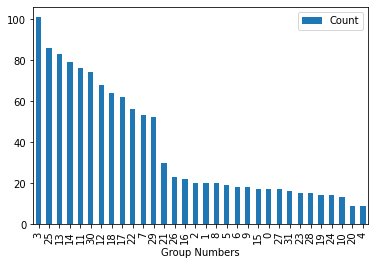

In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmclustered = KMeans(n_clusters=32, random_state=10).fit(S)
tempf = pd.DataFrame(kmclustered.labels_).value_counts().reset_index(name="Count")
pd.DataFrame(tempf).plot.bar(x=0, y="Count", xlabel="Group Numbers")

**The results here have groups that are much more uniform (although not perfectly so) in terms of group membership. This is likely because \#2's method looked *within* the data for points that were very close to *each other*, while the k-means algorithm started *outside* the data and moved inwards, looking for points that were closest to *its own centroids* (which would still be fairly distant from any/all other points; i.e. *less stringent* than \#2's, leading to bigger groups with more possible members).**